# **Multi Task Learning**

In this notebook we will learn how to use Multi-Task Learning to train a model to simultaneously segment and predict depth on a single image

### References:
- https://arxiv.org/pdf/1705.07115.pdf
- https://arxiv.org/pdf/1706.05587.pdf
- https://cs.nyu.edu/~silberman/papers/indoor_seg_support.pdf

In [1]:
import os

import numpy as np
import h5py
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from nyu_dataset import NyuDataset
from utils import *

%matplotlib inline

## CONFIGs

In [2]:
BATCH_SIZE = 2 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get Train/Valid/Test split

Since we are accessing the .mat file as an h5 object, we will make 2 datasets one for training and the other for valid/test/inference. If we set the random seed, this will allow us to get the appropriate splits.

In [3]:
root = r"C:\Users\itber\Documents\datasets\nyu_depth_seg\nyu_depth_v2_labeled.mat"

In [4]:
train_augmentations = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop((240, 320)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1, 1)),
    transforms.ElasticTransform(alpha=25.0, sigma=5.0),
])

test_augmentations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((240, 320)),
])

train_nyu_dataset = NyuDataset(root, augmentations=train_augmentations, normalize=True, depth_norm=10)
test_nyu_dataset = NyuDataset(root, augmentations=test_augmentations, normalize=True, depth_norm=10)

In [5]:
from torch.utils.data import random_split

seed = 42

# get train split
num_train = round(0.7*len(train_nyu_dataset))
num_remain = round(0.3*len(train_nyu_dataset))
(train_dataset, _) = random_split(train_nyu_dataset,
                                              [num_train, num_remain],
                                              generator=torch.Generator().manual_seed(seed))

""" 
Sketchy hack to get valid/test datasets
"""

(_, remain_dataset) = random_split(test_nyu_dataset,
                                              [num_train, num_remain],
                                              generator=torch.Generator().manual_seed(seed))

# get valid and test split
num_valid = round(0.8*len(remain_dataset))
num_test = round(0.2*len(remain_dataset))
(valid_dataset, test_dataset) = random_split(remain_dataset,
                                             [num_valid, num_test],
                                              generator=torch.Generator().manual_seed(seed))

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) 
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [7]:
image, (depth, label) = next(iter(train_dataloader))

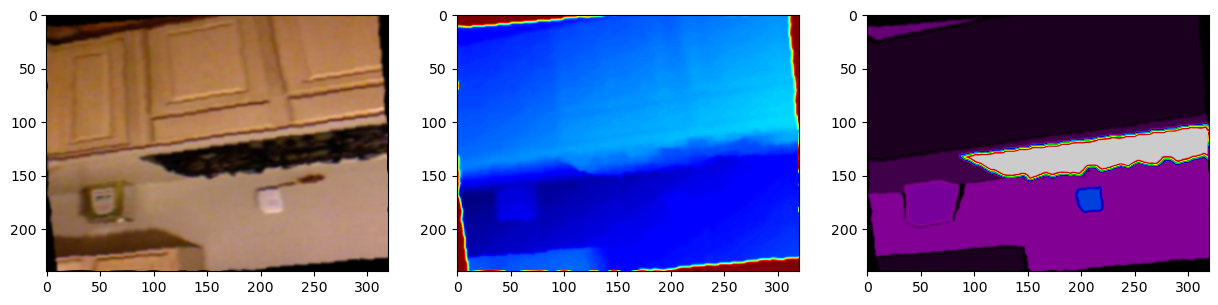

In [8]:
# get format for display
idx = 1
image_np, depth_np, label_np = convert_to_numpy(image[idx], depth[idx], label[idx])

_, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(image_np)
ax[1].imshow(depth_np, cmap='jet_r')
ax[2].imshow(label_np, cmap='nipy_spectral');

## Build Multi-Task Models


### We will take pre-trained models and Chop them up into the Multi-Headed model that we want. We will do this in two different ways. 

1. We will chop up the pretrained DeepLabV3 model. It's backbone is trained on Image Not and the head is trained for segmentation on the MSCOCO dataset. This allows us to have pretrained weights for all bloack of our network 

2. We will download the backbone and use the source code to generate our own DeepLabV3 Head. This allows us to have a pretrained backbone, but our DeepLab head will not always be pretrained, it will only be pretrained if we use a specific architecture that was already pretrained. This is useful for distilling knowledge into smaller models that are not readily available.


Look at this [resource](https://discuss.pytorch.org/t/how-can-i-replace-the-forward-method-of-a-predefined-torchvision-model-with-my-customized-forward-function/54224/7) to learn how to make a custom forward function for the backbone

#### Download Pretrained models

In [27]:
from torchvision.models import resnet50, mobilenet_v3_small
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_mobilenet_v3_large


# get backbone and download pretrained weights
resnet_backbone = resnet50(weights='IMAGENET1K_V1',
                    replace_stride_with_dilation=[False, True, True] # add atriuos convolutions
                    ) 
mobilenet_backbone = mobilenet_v3_small(weights='IMAGENET1K_V1', dilated=True) 

deeplabv3 = deeplabv3_resnet50(weights='COCO_WITH_VOC_LABELS_V1', 
                               weights_backbone='IMAGENET1K_V1', 
                               # aux_classifier=None
                               aux_loss=False
                               )

ValueError: The parameter 'aux_loss' expected value True but got False instead.

In [ ]:
deeplabv3

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Get pretrained blocks from DeepLabV3

In [29]:
from copy import deepcopy

# aggregate layers so that we can use a new forward function
backbone = nn.Sequential(*nn.ModuleList(deeplabv3.backbone.children()))
seg_head = deepcopy(deeplabv3.classifier)
depth_head = deepcopy(deeplabv3.classifier)

Add correct outputs

In [30]:
num_seg_classes = len(train_nyu_dataset.names[0])

seg_head[4] = torch.nn.Conv2d(256, num_seg_classes, kernel_size=(1, 1), stride=(1, 1))
depth_head[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

### Build the Multi Task Model class

In [31]:
class MultiTaskModel(nn.Module):
    def __init__(self, backbone, seg_head, depth_head):
        super().__init__()

        self.backbone = backbone
        self.seg_head = seg_head
        self.depth_head = depth_head
        
    def forward(self, x):
        input_shape = x.shape[-2:]

        features = self.backbone(x)

        seg_pred = self.seg_head(features)
        depth_pred = self.depth_head(features)

        # upsample predictions to initial input size
        seg_pred = F.interpolate(seg_pred, size=input_shape, mode="bilinear", align_corners=False)
        depth_pred = F.interpolate(depth_pred, size=input_shape, mode="bilinear", align_corners=False)

        return  (seg_pred, depth_pred)

### Build Model and run a forward pass

In [32]:
model = MultiTaskModel(backbone, seg_head, depth_head)

In [33]:
model.to(device)
outputs = model(image.to(device))

In [35]:
outputs[0].shape, outputs[1].shape

(torch.Size([2, 894, 240, 320]), torch.Size([2, 1, 240, 320]))

### Now use a smaller backbone with a custom Head

For this we will leverage code from torchvision, instead of importing, we will copy it so we can what we are working with

In [36]:
""" from torch vision DeepLabV3 Code
    https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/deeplabv3.py
"""
from typing import List

class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels: int, num_classes: int) -> None:
        super().__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1),
        )


class ASPPConv(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, dilation: int) -> None:
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ]
        super().__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode="bilinear", align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels: int, atrous_rates: List[int], out_channels: int = 256) -> None:
        super().__init__()
        modules = []
        modules.append(
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU())
        )

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _res = []
        for conv in self.convs:
            _res.append(conv(x))
        res = torch.cat(_res, dim=1)
        return self.project(res)


Now we will load all the weights for DeepLab, extract the weights for the head and load them into our custom heads

In [69]:
weights_path = r"C:\Users\itber\.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth"
deeplabv3_weights = torch.load(weights_path)

# get only DeepLabHead weights
deeplab_head = {k : v for k,v in deeplabv3_weights.items() if ('classifier' in k) and ('aux' not in k)}

deeplab_head = {}
for k,v in deeplabv3_weights.items():
    if ('classifier' in k) and ('aux' not in k):
        k = k.replace('classifier.', '')
        deeplab_head.update({k : v})

In [101]:
# use original shape for resnet50
seg_head = DeepLabHead(2048, 21)
depth_head = DeepLabHead(2048, 21)

seg_head.load_state_dict(deeplab_head)
depth_head.load_state_dict(deeplab_head)

# add desired outputs to final layer
seg_head[4] = torch.nn.Conv2d(256, num_seg_classes, kernel_size=(1, 1), stride=(1, 1))
depth_head[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))


Get resent50 backbone

In [73]:
backbone = nn.Sequential(*nn.ModuleList(resnet_backbone.children())[:-2]) # remove last 2 layers of resnet

Build model and run forward pass

In [74]:
model = MultiTaskModel(backbone, seg_head, depth_head)

In [75]:
model.to(device)
outputs = model(image.to(device))

In [76]:
outputs[0].shape, outputs[1].shape

(torch.Size([2, 894, 240, 320]), torch.Size([2, 1, 240, 320]))

Now build custom model with MobileNet Small backbone, we will not be able to use pretrained weights here

In [87]:
# deeplabv3 = deeplabv3_mobilenet_v3_large(weights='COCO_WITH_VOC_LABELS_V1', weights_backbone='IMAGENET1K_V1')

In [104]:
# get pretrained backbone
backbone = nn.Sequential(*nn.ModuleList(mobilenet_backbone.children())[:-2]) # remove last 2 layers of mobilenet

# get heads with newly initialized weights
seg_head = DeepLabHead(576, num_seg_classes)
depth_head = DeepLabHead(576, 1)

Build Model and run forward pass

In [105]:
model = MultiTaskModel(backbone, seg_head, depth_head)

In [106]:
model.to(device)
outputs = model(image.to(device))

In [107]:
outputs[0].shape, outputs[1].shape

(torch.Size([2, 894, 240, 320]), torch.Size([2, 1, 240, 320]))